In [5]:
! pip install pandas
! pip install numpy
! pip install joblib

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score
import joblib
from pathlib import Path

In [4]:
files = [
#   "/Users/selen/Downloads/pp-2023.csv",
#   "/Users/selen/Downloads/pp-2024.csv",
    "/Users/selen/Downloads/pp-2025.csv",
]

colnames = [
    "TransactionID","Price","Date","Postcode","PropertyType","OldNew","Duration",
    "PAON","SAON","Street","Locality","TownCity","District","County",
    "PPDCategoryType","RecordStatus"
]

dfs = []
for f in files:
    print("Reading:", f)
    df_i = pd.read_csv(f, header=None, names=colnames, low_memory=False)
    dfs.append(df_i)

df = pd.concat(dfs, ignore_index=True)
print("Loaded rows:", len(df))


Reading: /Users/selen/Downloads/pp-2025.csv
Loaded rows: 376633


In [5]:
# ==== B. 最小清洗 ====
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date","Price","Postcode"])
df = df[df["Price"] > 0]

In [17]:
# ==== C. 聚合到 邮编×月份（保留大量类别特征）====
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date","Price","Postcode"])
df = df[df["Price"] > 0]
df["YearMonth"] = df["Date"].dt.to_period("M").astype(str)

# 2) 只取外部码（outward code），统一大小写/空格
pc = df["Postcode"].astype(str).str.upper().str.strip()
pc = pc.str.replace(r"\s+", " ", regex=True)      # 多空格合一
df["PostcodePrefix"] = pc.str.split(" ").str[0]   # "SW7 7YH" -> "SW7"
# 备选：对极少数无空格样本，正则兜底
mask_no_space = ~pc.str.contains(" ")
df.loc[mask_no_space, "PostcodePrefix"] = pc[mask_no_space].str.extract(r"^([A-Z]{1,2}\d{1,2}[A-Z]?)", expand=False)

# 3) 分组列（地区只用外部码；其余保留小类）
group_cols = ["PostcodePrefix", "YearMonth", "PropertyType", "OldNew", "Duration",
              "PPDCategoryType"]  # 先不把 Town/District/County 放进分组，后面当特征用即可

monthly = (
    df.groupby(group_cols, dropna=False)
      .agg(avg_price=("Price","mean"),
           n_tx=("Price","count"))
      .reset_index()
)

# 4) 快速检查（可留可删）
print("monthly shape:", monthly.shape)
print("top outward codes:", monthly["PostcodePrefix"].value_counts().head(10).to_dict())

monthly shape: (91266, 8)
top outward codes: {'PR7': 92, 'WN2': 91, 'WA8': 87, 'PR2': 86, 'M24': 85, 'NE28': 84, 'WA4': 84, 'BL1': 83, 'SK14': 83, 'WN7': 83}


In [ ]:
# ==== D. 造标签：对每个“外部码(前缀)”做环比 ====
monthly = monthly.sort_values(["PostcodePrefix", "YearMonth"])

# 上月均价（在同一外部码内取上一期）
monthly["prev_avg_price"] = (
    monthly.groupby("PostcodePrefix")["avg_price"].shift(1)
)

# 环比涨跌比例
monthly["mom_change"] = (
    (monthly["avg_price"] - monthly["prev_avg_price"]) / monthly["prev_avg_price"]
)

# 去掉没有上一期的数据
monthly = monthly.dropna(subset=["prev_avg_price"]).reset_index(drop=True)

# 涨跌标签：涨=1，跌=0
monthly["trend"] = (monthly["mom_change"] > 0).astype(int)

# 月份数值特征
monthly["month"] = monthly["YearMonth"].str[-2:].astype(int)

#（可选）快速看一眼
print("D done:", monthly[["PostcodePrefix","YearMonth","avg_price","prev_avg_price","mom_change","trend"]].head())


D done:   PostcodePrefix YearMonth     avg_price  prev_avg_price  mom_change  trend
0            AL1   2025-01  3.732500e+05   307830.315789    0.212519      1
1            AL1   2025-01  8.283333e+05   373250.000000    1.219245      1
2            AL1   2025-01  6.368986e+05   828333.333333   -0.231108      0
3            AL1   2025-01  3.400000e+05   636898.555556   -0.466163      0
4            AL1   2025-02  1.514286e+06   340000.000000    3.453782      1


In [ ]:
# ==== E. 构建特征 + 编码器（不做切分/训练） ====

# 数值 & 类别特征
num_feats  = ["avg_price", "prev_avg_price", "mom_change", "n_tx", "month"]
cat_small  = ["PropertyType", "OldNew", "Duration", "PPDCategoryType"]   # 小基数：完整 one-hot
cat_big    = ["PostcodePrefix"]  # 大基数先只用“外部码”；District/Town后面再视情况加

# 训练数据矩阵（先不切分）
X = monthly[num_feats + cat_small + cat_big].copy()
y = monthly["trend"].astype(int)

# 动态低频阈值：≥200 次 或 ≥ 2%（取更大的那个）
mf = max(200, int(0.02 * len(X)))

# 编码器：数值标准化；小类完整 one-hot；大类低频自动合并 + 稀疏输出（省内存/更快）
pre = ColumnTransformer([
    ("num",       StandardScaler(), num_feats),
    ("cat_small", OneHotEncoder(handle_unknown="ignore",
                                sparse_output=True),                   cat_small),
    ("cat_big",   OneHotEncoder(handle_unknown="infrequent_if_exist",
                                min_frequency=mf,  # 低频并入 infrequent 桶
                                sparse_output=True),                   cat_big)
])

print("E-section ready. X shape:", X.shape, " | min_frequency used:", mf)


E-section ready. X shape: (86717, 8)  | min_frequency used: 1734


In [20]:
# 时间切分：按月份排序后，前80%做训练，后20%做测试
all_months = sorted(monthly["YearMonth"].unique())
cut = int(len(all_months) * 0.8)

train_months = set(all_months[:cut])
is_train = monthly["YearMonth"].isin(train_months)

X_train, y_train = X[is_train], y[is_train]
X_test,  y_test  = X[~is_train], y[~is_train]

print(f"Train samples: {len(X_train)} | Test samples: {len(X_test)} | Train months: {len(train_months)} / {len(all_months)}")


Train samples: 70469 | Test samples: 18515 | Train months: 6 / 8


In [24]:
# ==== 用训练集规模设置低频阈值 + saga 逻辑回归） ====

# 1) 用训练集规模重新设定低频合并阈值（更合理）
mf = max(500, int(0.05 * len(X_train)))   # 原来max(200, 0.02N) -> max(500, 0.05N)
print("min_frequency used:", mf)

# 2) 重新构建编码器（保证阈值用的是训练集）
pre = ColumnTransformer([
    ("num",       StandardScaler(), num_feats),
    ("cat_small", OneHotEncoder(handle_unknown="ignore",
                                sparse_output=True),                   cat_small),
    ("cat_big",   OneHotEncoder(handle_unknown="infrequent_if_exist",
                                min_frequency=mf,
                                sparse_output=True),                   cat_big)
])

# 3) 模型：saga 逻辑回归（适配高维稀疏，速度快，概率靠谱）
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ("prep", pre),
    ("clf", LogisticRegression(
        solver="saga",
        penalty="l2",
        C=0.5,          # 正则更强(默认1.0 -> 0.5)，更稳更快收敛
        max_iter=600,   # 稍加迭代
        tol=1e-3,       # 收敛容差放宽(默认1e-4 -> 1e-3)，更快
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    ))
])




min_frequency used: 3523


In [25]:
# 4) 训练 
import time
t0 = time.time()
pipe.fit(X_train, y_train)
print(f"fit done in {time.time()-t0:.1f}s")

fit done in 311.7s


In [26]:
#评估（轻量）
pred  = pipe.predict(X_test)
proba = pipe.predict_proba(X_test)[:, 1]

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
print("Accuracy:", round(accuracy_score(y_test, pred), 4))
print("F1:",       round(f1_score(y_test, pred), 4))
try:
    print("AUC:",  round(roc_auc_score(y_test, proba), 4))
except: pass


Accuracy: 0.9641
F1: 0.9609
AUC: 0.9963


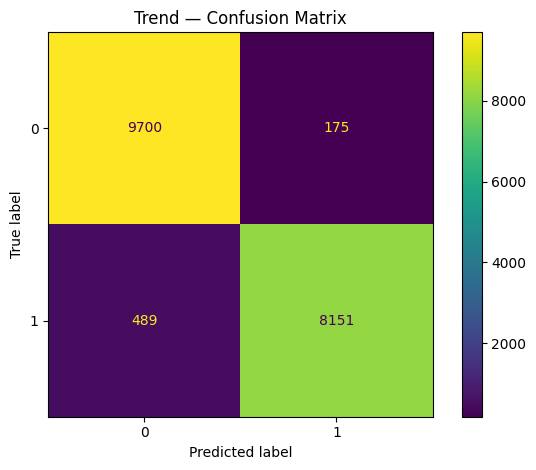

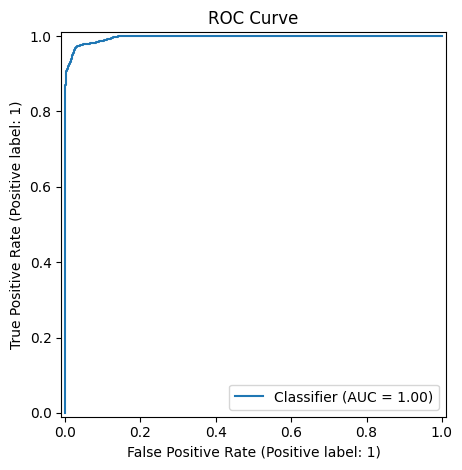

In [ ]:
# 一张图（很快）
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

ConfusionMatrixDisplay(confusion_matrix(y_test, pred, labels=[0,1]))\
    .plot(values_format="d")
plt.title("Trend — Confusion Matrix")
plt.tight_layout(); plt.show()

RocCurveDisplay.from_predictions(y_test, proba)
plt.title("ROC Curve")
plt.tight_layout(); plt.show()


In [ ]:
# === A. 过拟合快速体检：Train vs Test 指标 ===
def eval_split(name, y_true, pred, proba):
    from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
    acc = accuracy_score(y_true, pred)
    f1  = f1_score(y_true, pred)
    try:
        auc = roc_auc_score(y_true, proba)
    except Exception:
        auc = float('nan')
    print(f"{name:>6} | Acc: {acc:.4f}  F1: {f1:.4f}  AUC: {auc:.4f}  | size={len(y_true)}")

# 训练集表现
pred_tr  = pipe.predict(X_train)
proba_tr = pipe.predict_proba(X_train)[:, 1]
eval_split("Train", y_train, pred_tr, proba_tr)

# 测试集表现
pred_te  = pipe.predict(X_test)
proba_te = pipe.predict_proba(X_test)[:, 1]
eval_split(" Test", y_test, pred_te, proba_te)

# 类别分布（检查是否极度不平衡）
print("\nLabel balance -> Train:", y_train.value_counts().to_dict(),
      "| Test:", y_test.value_counts().to_dict())


 Train | Acc: 0.9547  F1: 0.9488  AUC: 0.9945  | size=70469
  Test | Acc: 0.9641  F1: 0.9609  AUC: 0.9963  | size=18515

Label balance -> Train: {0: 38602, 1: 31867} | Test: {0: 9875, 1: 8640}
